In [220]:
import pandas as pd
import numpy as np 
import pymc as pm 
import arviz as az
import xarray as xr
from causalgraphicalmodels import CausalGraphicalModel
import jax

import matplotlib.pyplot as plt
# Load the data
data = pd.read_csv('../data/nyc_regression_data.csv')
data

,precinct,perp_race,perp_sex,age_group,ofns_desc,law_cat_cd
0,1.0,WHITE,M,25-44,CRIMINAL MISCHIEF & RELATED OF,M
1,1.0,BLACK,M,25-44,FELONY ASSAULT,F
2,1.0,WHITE HISPANIC,M,45-64,CRIMINAL TRESPASS,M
3,1.0,BLACK,M,45-64,ASSAULT 3 & RELATED OFFENSES,M
4,1.0,WHITE,M,45-64,OTHER STATE LAWS,V
...,...,...,...,...,...,...
63610,123.0,WHITE,M,18-24,DANGEROUS WEAPONS,F
63611,123.0,WHITE,M,25-44,ROBBERY,F
63612,123.0,BLACK,F,18-24,FELONY ASSAULT,F
63613,123.0,BLACK,F,45-64,FELONY ASSAULT,F


In [11]:
data_m_f = data[(data["law_cat_cd"].isin(["M", "F"]))]
data_m_f

,precinct,perp_race,perp_sex,age_group,ofns_desc,law_cat_cd
0,1.0,WHITE,M,25-44,CRIMINAL MISCHIEF & RELATED OF,M
1,1.0,BLACK,M,25-44,FELONY ASSAULT,F
2,1.0,WHITE HISPANIC,M,45-64,CRIMINAL TRESPASS,M
3,1.0,BLACK,M,45-64,ASSAULT 3 & RELATED OFFENSES,M
5,1.0,WHITE HISPANIC,M,25-44,DANGEROUS DRUGS,M
...,...,...,...,...,...,...
63610,123.0,WHITE,M,18-24,DANGEROUS WEAPONS,F
63611,123.0,WHITE,M,25-44,ROBBERY,F
63612,123.0,BLACK,F,18-24,FELONY ASSAULT,F
63613,123.0,BLACK,F,45-64,FELONY ASSAULT,F


In [12]:
data_m_f["perp_race"] = data_m_f["perp_race"].apply(lambda x: "BLACK" if "BLACK" in x else "NON BLACK")

/tmp/ipykernel_10000/2538464095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_m_f["perp_race"] = data_m_f["perp_race"].apply(lambda x: "BLACK" if "BLACK" in x else "NON BLACK")


# Number of crimes

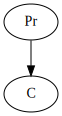

In [221]:
growth = CausalGraphicalModel(
    nodes=["Pr", "C"],
    edges=[
        ("Pr", "C"), 
    ]
)

growth.draw()

In [36]:
data_grouped = data_m_f.groupby(["precinct"])["perp_race"].value_counts().reset_index(name="count")
data_grouped

,precinct,perp_race,count
0,1.0,NON BLACK,409
1,1.0,BLACK,392
2,5.0,NON BLACK,383
3,5.0,BLACK,367
4,6.0,BLACK,318
...,...,...,...
149,121.0,BLACK,369
150,122.0,NON BLACK,303
151,122.0,BLACK,99
152,123.0,NON BLACK,255


In [137]:
X = data_grouped.drop(columns=["count"])
y = data_grouped["count"]

In [155]:
X_enc = pd.get_dummies(X, columns=["precinct", "perp_race"], dtype=float)

In [160]:
with pm.Model() as precinct_count_model_2:
    beta = pm.Normal('beta', mu=0, sigma=1.5, shape=len(X_enc.columns) - 2)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(pm.math.dot(X_enc.iloc[:,:-2], beta)))
    
    crime = pm.Poisson('crime', lambda_, observed=y)

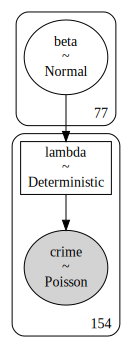

In [161]:
pm.model_to_graphviz(precinct_count_model_2)

In [162]:
with precinct_count_model_2:
    prior_checks = pm.sample_prior_predictive(samples=100)

Sampling: [beta, crime]


In [163]:
with precinct_count_model_2:

    precinct_count_trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs=dict(log_likelihood=True), cores=4,nuts_sampler="numpyro")

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.10/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 2000/2000 [00:13<00:00, 153.25it/s, 15 steps of size 4.04e-01. acc. prob=0.90]


In [164]:
az.summary(precinct_count_trace, var_names=["beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],5.988,0.036,5.922,6.052,0.000,0.000,5261.0,3050.0,1.0
beta[1],5.923,0.036,5.854,5.985,0.000,0.000,6714.0,3061.0,1.0
beta[2],5.574,0.044,5.495,5.658,0.001,0.000,5862.0,2759.0,1.0
beta[3],5.676,0.041,5.597,5.754,0.001,0.000,5599.0,2731.0,1.0
beta[4],5.518,0.045,5.427,5.598,0.001,0.000,5773.0,2620.0,1.0
...,...,...,...,...,...,...,...,...,...
beta[72],6.435,0.029,6.382,6.491,0.000,0.000,6739.0,2700.0,1.0
beta[73],6.531,0.027,6.483,6.583,0.000,0.000,6100.0,3055.0,1.0
beta[74],5.974,0.036,5.904,6.038,0.000,0.000,5414.0,2834.0,1.0
beta[75],5.297,0.050,5.201,5.386,0.001,0.000,6279.0,2901.0,1.0


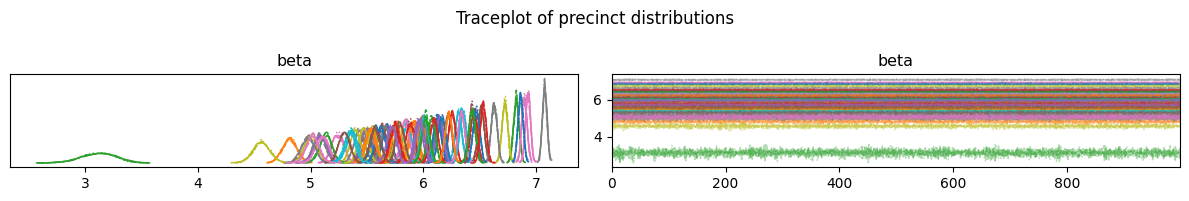

In [223]:
az.plot_trace(precinct_count_trace, var_names=["beta"])
plt.suptitle("Traceplot of precinct distributions")
plt.tight_layout()

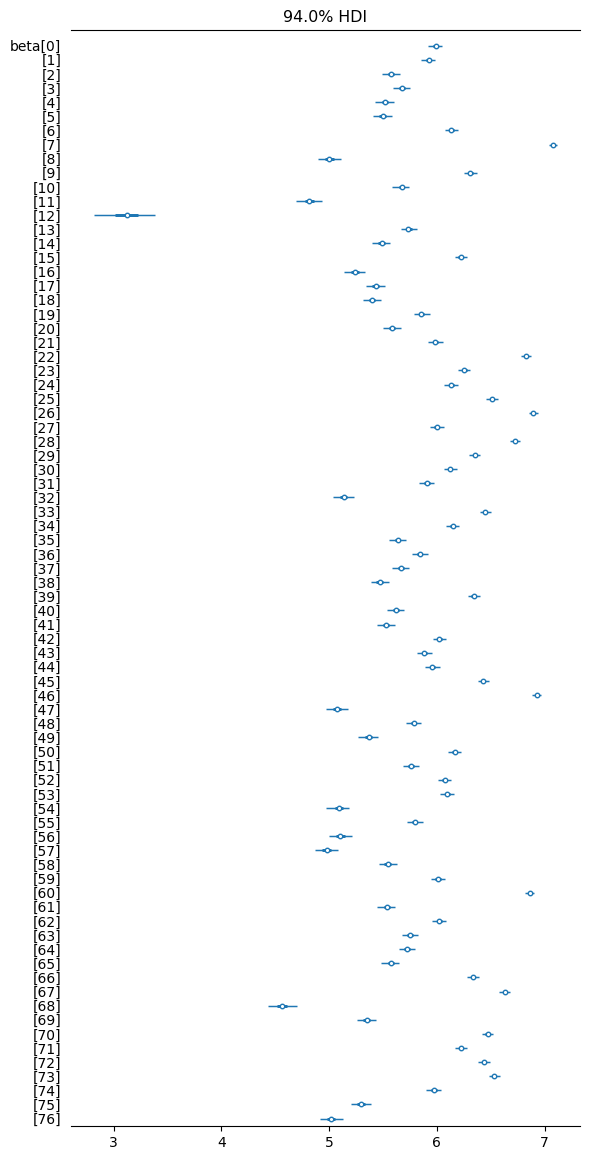

In [224]:
az.plot_forest(precinct_count_trace, combined=True, var_names=["beta"], textsize=10)

plt.tight_layout()

## Precinct and Race

In [24]:
data_grouped['perp_race']

0      NON BLACK
1          BLACK
2      NON BLACK
3          BLACK
4          BLACK
         ...    
149        BLACK
150    NON BLACK
151        BLACK
152    NON BLACK
153        BLACK
Name: perp_race, Length: 154, dtype: object

In [186]:
with pm.Model() as precinct_race_count_model:
    beta = pm.Normal('beta', mu=0, sigma=1.5, shape=len(X_enc.columns) - 2)
    epsilon = pm.Normal('epsilon', mu=5, sigma=1.5, shape=2)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(pm.math.dot(X_enc.iloc[:,:-2], beta) + pm.math.dot(X_enc.iloc[:,-2:], epsilon)))
    
    crime = pm.Poisson('crime', lambda_, observed=y)

In [187]:
with precinct_race_count_model:
    prior_checks = pm.sample_prior_predictive(samples=100)

Sampling: [beta, crime, epsilon]


In [188]:
with precinct_race_count_model:
    precinct_race_count_trace = pm.sample(2000, tune=2000, return_inferencedata=True, cores=4, idata_kwargs=dict(log_likelihood=True), nuts_sampler="numpyro")

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.10/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4000/4000 [00:53<00:00, 75.04it/s, 31 steps of size 3.65e-02. acc. prob=0.88] 
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [189]:
az.summary(precinct_race_count_trace, var_names=["beta", "epsilon"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.152,0.152,-0.131,0.428,0.032,0.023,23.0,89.0,1.15
beta[1],0.086,0.152,-0.199,0.362,0.032,0.023,24.0,94.0,1.15
beta[2],-0.262,0.155,-0.561,0.013,0.032,0.023,24.0,91.0,1.14
beta[3],-0.159,0.153,-0.442,0.127,0.031,0.023,24.0,92.0,1.14
beta[4],-0.318,0.154,-0.599,-0.029,0.032,0.023,24.0,88.0,1.15
...,...,...,...,...,...,...,...,...,...
beta[74],0.137,0.152,-0.146,0.418,0.032,0.023,23.0,91.0,1.15
beta[75],-0.538,0.156,-0.837,-0.254,0.032,0.023,24.0,100.0,1.15
beta[76],-0.813,0.158,-1.102,-0.517,0.031,0.023,26.0,88.0,1.13
epsilon[0],5.963,0.148,5.685,6.230,0.032,0.023,22.0,86.0,1.16


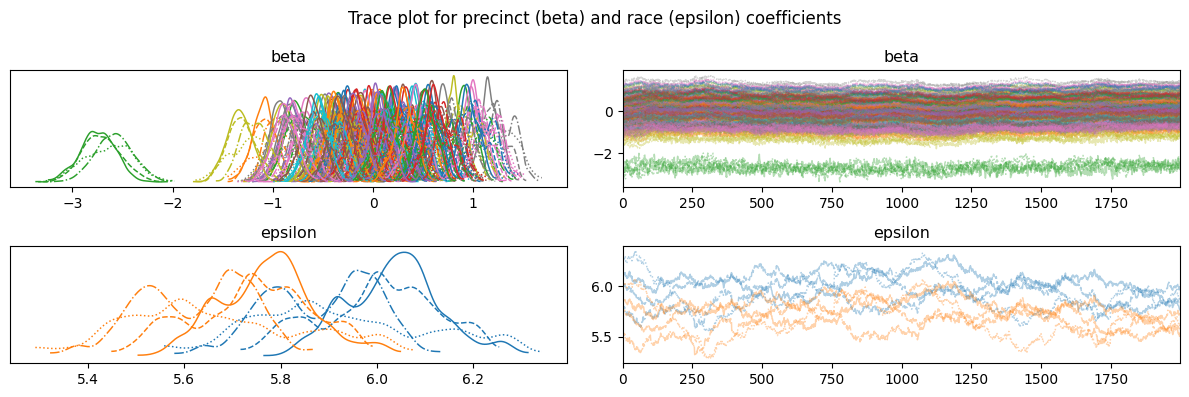

In [218]:
az.plot_trace(precinct_race_count_trace, var_names=["beta", "epsilon"])
plt.suptitle("Trace plot for precinct (beta) and race (epsilon) coefficients")
plt.tight_layout()

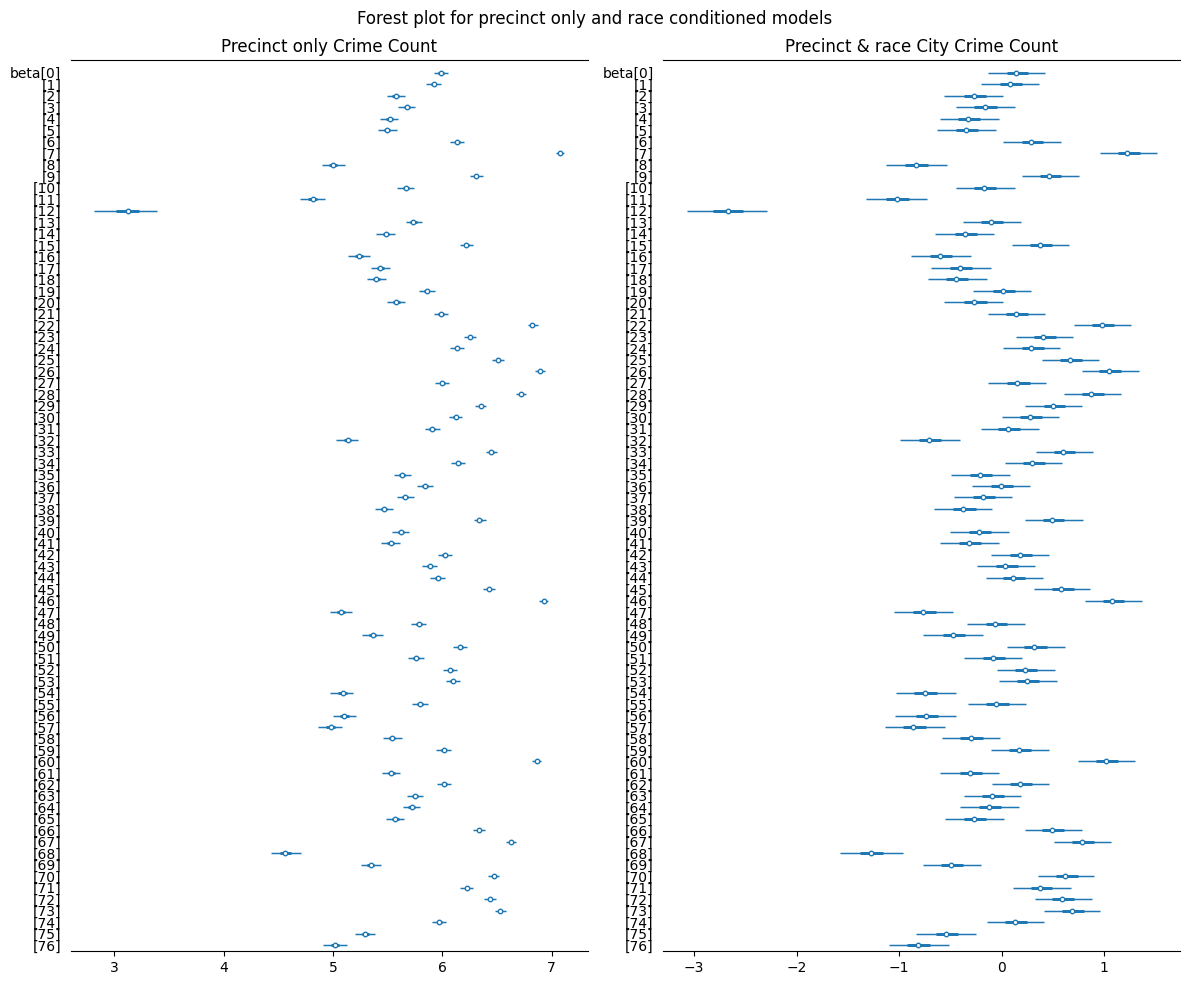

In [219]:
_, ax = plt.subplots(1, 2, figsize=(12, 10))

az.plot_forest(precinct_count_trace, combined=True, var_names=["beta"], ax=ax[0], textsize=10)
ax[0].set_title("Precinct only Crime Count")
az.plot_forest(precinct_race_count_trace, combined=True, var_names=["beta"], ax=ax[1], textsize=10)
ax[1].set_title("Precinct & race City Crime Count")
plt.suptitle("Forest plot for precinct only and race conditioned models")
plt.tight_layout()

## Debiasing

In [193]:
corr_ = X_enc.corr()

Text(0.5, 1.0, 'Correlation between non protected and protected features')

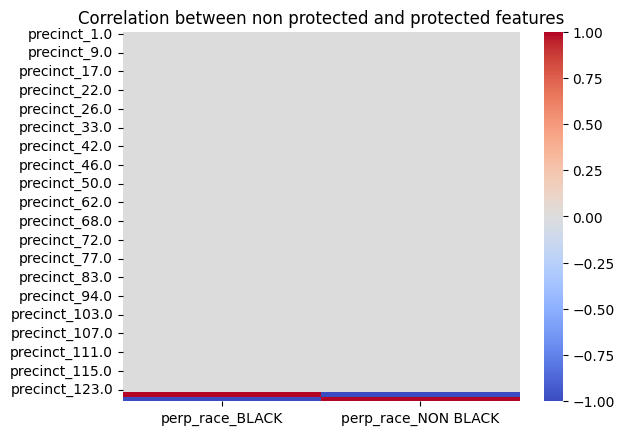

In [211]:
import seaborn as sns

sns.heatmap(corr_.iloc[:,-2:], vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Correlation between non protected and protected features")

In [195]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_enc)
X_enc_scaled = scaler.transform(X_enc)
# Transform scaled array back to DataFrame
Xs_df = pd.DataFrame(X_enc_scaled, index=X_enc.index, columns=X_enc.columns)

# Now Xs_train_df is your scaled DataFrame with the original index
# print(Xs_df)
n_features = Xs_df.shape[1]

Xs_p = Xs_df.iloc[:, -2:]
Xs_np = Xs_df.iloc[:, :-2]

In [196]:
from scipy.linalg import orth

def debias_features(Xs_np, Xs_p):
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np.apply(lambda X: X - X.dot(orthbasis).dot(orthbasis.T))

    # Return debiased nonprotected features
    return Xs_np_debiased

features_np_debiased = debias_features(Xs_np, Xs_p)
X_debiased = pd.concat([features_np_debiased, Xs_p], axis=1)

In [197]:
X_debiased

,precinct_1.0,precinct_5.0,precinct_6.0,precinct_7.0,precinct_9.0,precinct_10.0,precinct_13.0,precinct_14.0,precinct_17.0,precinct_18.0,...,precinct_112.0,precinct_113.0,precinct_114.0,precinct_115.0,precinct_120.0,precinct_121.0,precinct_122.0,precinct_123.0,perp_race_BLACK,perp_race_NON BLACK
0,8.717798,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,...,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-1.0,1.0
1,8.717798,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,...,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,1.0,-1.0
2,-0.114708,8.717798,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,...,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-1.0,1.0
3,-0.114708,8.717798,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,...,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,1.0,-1.0
4,-0.114708,-0.114708,8.717798,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,...,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,...,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,8.717798,-0.114708,-0.114708,1.0,-1.0
150,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,...,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,8.717798,-0.114708,-1.0,1.0
151,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,...,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,8.717798,-0.114708,1.0,-1.0
152,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,...,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,-0.114708,8.717798,-1.0,1.0


In [200]:
with pm.Model() as debiased_crime_model:
    beta = pm.Normal('beta', mu=0, sigma=0.5, shape = len(X_debiased.columns) - 2)
    epsilon = pm.Normal('epsilon', mu=5, sigma=1.5, shape=2)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(pm.math.dot(X_debiased.iloc[:,:-2], beta) + pm.math.dot(X_debiased.iloc[:,-2:], epsilon)))
    
    crime = pm.Poisson('crime', lambda_, observed=y)

In [201]:
with debiased_crime_model:
    prior_checks = pm.sample_prior_predictive(samples=100)

Sampling: [beta, crime, epsilon]


In [202]:
with debiased_crime_model:
    debiased_crime_trace = pm.sample(2000, tune=2000, return_inferencedata=True, cores=4, idata_kwargs=dict(log_likelihood=True), nuts_sampler="numpyro")

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.10/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4000/4000 [04:04<00:00, 16.39it/s, 127 steps of size 3.41e-03. acc. prob=0.93] 
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [207]:
az.summary(debiased_crime_trace, var_names=["beta", "epsilon"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.638,0.047,0.563,0.714,0.022,0.016,5.0,19.0,2.26
beta[1],0.630,0.047,0.552,0.702,0.022,0.016,5.0,21.0,2.25
beta[2],0.585,0.047,0.509,0.660,0.022,0.016,5.0,19.0,2.24
beta[3],0.599,0.047,0.522,0.673,0.022,0.016,5.0,19.0,2.24
beta[4],0.578,0.047,0.502,0.653,0.022,0.016,5.0,19.0,2.24
...,...,...,...,...,...,...,...,...,...
beta[74],0.636,0.047,0.560,0.710,0.022,0.016,5.0,19.0,2.25
beta[75],0.548,0.047,0.471,0.624,0.022,0.016,5.0,18.0,2.22
beta[76],0.510,0.047,0.431,0.585,0.022,0.016,5.0,20.0,2.19
epsilon[0],4.957,1.059,3.038,7.017,0.105,0.076,106.0,295.0,1.04


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'epsilon'}>,
        <Axes: title={'center': 'epsilon'}>]], dtype=object)

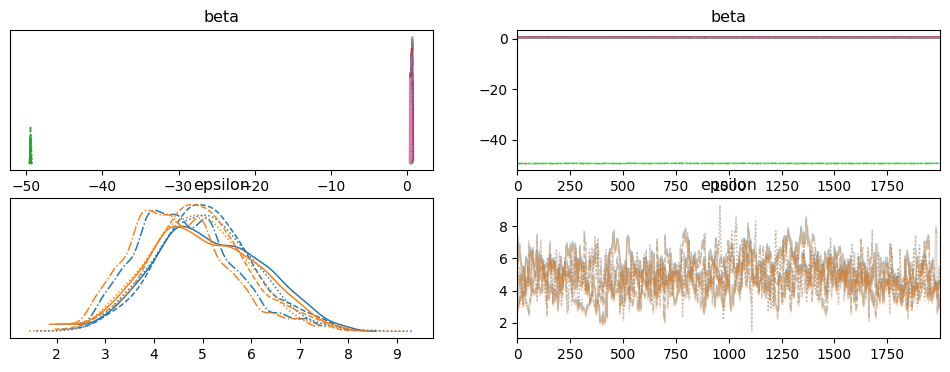

In [205]:
az.plot_trace(debiased_crime_trace, var_names=["beta", "epsilon"])

Text(0.5, 1.0, 'Precinct & race City Crime Count')

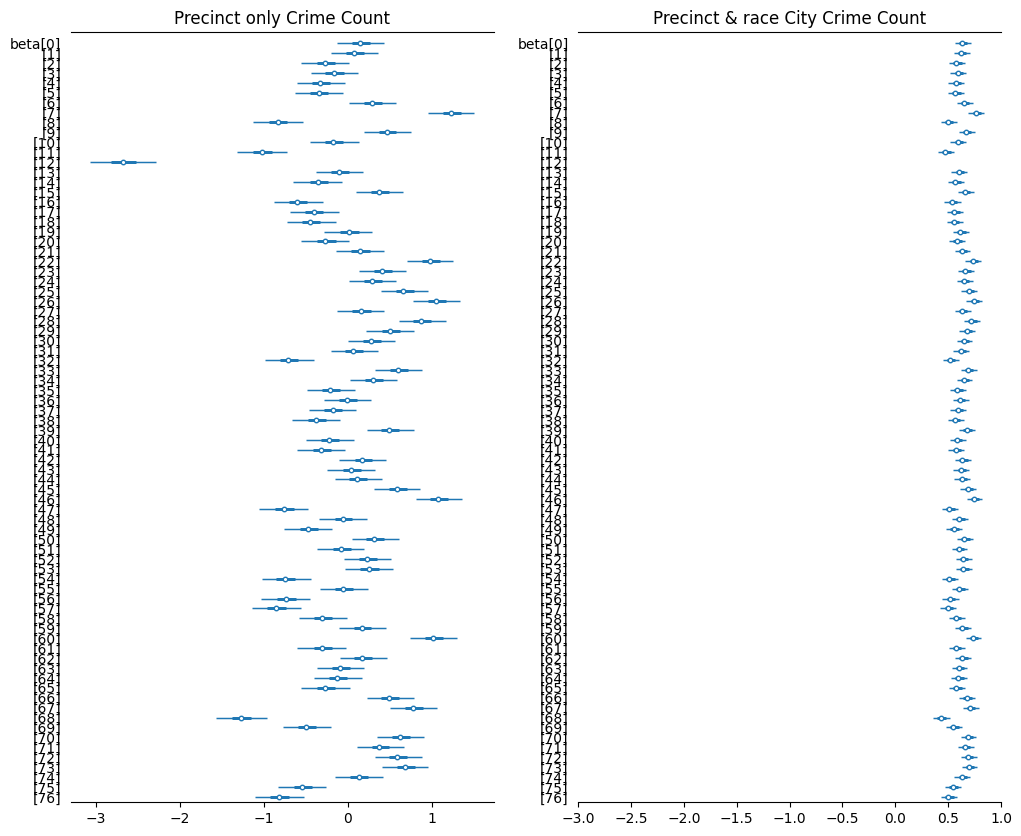

In [210]:
_, ax = plt.subplots(1, 2, figsize=(12, 10))

az.plot_forest(precinct_race_count_trace, combined=True, var_names=["beta"], ax=ax[0], textsize=10)
ax[0].set_title("Precinct only Crime Count")
az.plot_forest(debiased_crime_trace, combined=True, var_names=["beta"], ax=ax[1], textsize=10)
ax[1].set_xlim(-3, 1)
ax[1].set_title("Precinct & race City Crime Count")
